In [135]:
import pandas
import math
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import re
from rapidfuzz import process, fuzz
import time
import numpy as np
import time

In [117]:
df = pandas.read_csv('company_directorships.csv')
df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)

# Load a dataset about company directorships.
# Clean/transform the software_background column so it's easier to work with (converting 't' and 'f' to True and False).
# Display a random sample of 5 rows for inspection or analysis.

,company_name,cikcode,director_name,software_background,start_date,end_date
10145,ROBERT HALF INC.,315213,"ANDREW S. BERWICK, JR.",False,2006-03-24,2016-04-15
5038,GEE Group Inc.,40570,JOSEPH F. LIZZADRO,False,2002-01-14,2007-01-22
3455,"Dine Brands Global, Inc.",49754,GILBERT T. RAY,False,2017-04-03,2020-04-01
1423,"Bath & Body Works, Inc.",701985,THOMAS J. KUHN,False,2023-04-18,2023-04-18
4764,FONAR CORP,355019,JOHN COLLINS,False,2022-04-08,2022-04-08


In [118]:
#data wrangling and aggregation pipeline code that processes director compensation and demographic data.

#dataset of director details.
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')

#Standardizes name formatting (name in upper case and saved it in column name "NAME")
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

#This function returns the most common (mode) value in a Series.
def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None
    
#Groups the data by NAME (standardized names).
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),#Gets their maximum recorded age (age.max())
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),#Sums all their compensation (compensation.sum())
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)})#Gets their most frequent gender value (gender.agg(most_common))

#Log-transform the compensation
#Adds 1 to each compensation value to avoid taking log10(0) (which is undefined).
#Applies a base-10 logarithm to make large compensation numbers easier to analyze or visualize.
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)

#fINAL output, Displays the resulting cleaned and aggregated DataFrame.
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [119]:
!pip install rapidfuzz

# TASK 2 
## CODE REPAIR/REPLACE

### Repair 1

This code performs fuzzy name matching and merging between two datasets (directorships_df and directors_df) to align director records that may differ due to formatting inconsistencies. It first cleans the names by lowercasing, removing punctuation, and stripping common suffixes, then uses fuzzy string matching (with a similarity threshold of 85) to find the best match for each name in the directorships data against a list of unique names from the directors data. Matched entries are then merged into a single dataframe, and temporary columns used for cleaning and matching are dropped, resulting in a cleaned, consolidated view of matched director records.

In [120]:
# Define a function to clean director names
def clean_name(name):
    if pd.isna(name):
        return ""
    name = name.lower().strip()
    # Remove common suffixes, degrees, punctuation
    name = re.sub(r'\b(jr|sr|phd|m\.d\.|md|esq|ii|iii|iv|ph\.d|,|-)\b', '', name)
    name = re.sub(r'[^a-z\s]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

# Clean names in both dataframes
directorships_df['director_name_clean'] = directorships_df['director_name'].apply(clean_name)
directors_df['name_clean'] = directors_df['name'].apply(clean_name)

# Create a list of unique cleaned names from directors_df for matching
director_names_unique = directors_df['name_clean'].unique()

# Function to find best fuzzy match above a threshold
def match_name(name, choices, threshold=85):
    match = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= threshold:
        return match[0]
    return None

# Apply fuzzy matching to directorships_df cleaned names
directorships_df['matched_name_clean'] = directorships_df['director_name_clean'].apply(
    lambda x: match_name(x, director_names_unique)
)

# Filter rows with matches only
matched_df = directorships_df.dropna(subset=['matched_name_clean'])

# Merge on the cleaned matched names
merged_df = pd.merge(
    matched_df,
    directors_df,
    left_on='matched_name_clean',
    right_on='name_clean',
    how='inner',
    suffixes=('_directorship', '_director')
)

# Drop helper columns if desired
merged_df.drop(columns=['director_name_clean', 'name_clean', 'matched_name_clean'], inplace=True)

# Check the merged data
print(merged_df.head())

      company_name  cikcode              director_name software_background  \
0  1ST SOURCE CORP    34782  CHRISTOPHER J. MURPHY III                   t   
1  1ST SOURCE CORP    34782  CHRISTOPHER J. MURPHY III                   t   
2  1ST SOURCE CORP    34782   CHRISTOPHER J. MURPHY IV                   f   
3  1ST SOURCE CORP    34782   CHRISTOPHER J. MURPHY IV                   f   
4  1ST SOURCE CORP    34782      DANIEL B. FITZPATRICK                   f   

   start_date    end_date    id  \
0  2008-03-14  2025-03-14  1426   
1  2008-03-14  2025-03-14  1428   
2  2011-03-14  2025-03-14  1426   
3  2011-03-14  2025-03-14  1428   
4  2008-03-14  2025-03-14  1425   

                                                 url  \
0  https://www.sec.gov/Archives/edgar/data/34782/...   
1  https://www.sec.gov/Archives/edgar/data/34782/...   
2  https://www.sec.gov/Archives/edgar/data/34782/...   
3  https://www.sec.gov/Archives/edgar/data/34782/...   
4  https://www.sec.gov/Archives/edgar/da

# TASK 2 
## CODE REPAIR/REPLACE

### Repair 2

This code checks for potential data quality issues in two datasets—directorships_df and directors_df—by identifying duplicate director names and inconsistencies in formatting. It first detects and prints duplicate names in each dataset. Then, it standardizes the name formats by trimming whitespace and converting to lowercase, and compares the cleaned name sets from both datasets to identify names that appear in one dataset but not the other. These discrepancies, often due to minor formatting differences like casing or spacing, highlight potential mismatches that could affect data merging or analysis.

In [121]:
# 1. Check for duplicate director names in directorships_df
print("Duplicate director names in directorships_df:")
duplicate_directors_in_directorships = directorships_df['director_name'].duplicated(keep=False)
print(directorships_df[duplicate_directors_in_directorships]['director_name'].value_counts())

# 2. Check for duplicate director names in directors_df
print("\nDuplicate director names in directors_df:")
duplicate_directors_in_directors = directors_df['name'].duplicated(keep=False)
print(directors_df[duplicate_directors_in_directors]['name'].value_counts())

# 3. Check for inconsistencies like leading/trailing spaces or case differences
print("\nChecking for inconsistencies due to spacing or casing:")

# Trim whitespace and lower case the names to compare
directorships_df['director_name_clean'] = directorships_df['director_name'].str.strip().str.lower()
directors_df['name_clean'] = directors_df['name'].str.strip().str.lower()

# Find names that differ only by casing or spaces by comparing unique sets
directorship_names_set = set(directorships_df['director_name_clean'].unique())
directors_names_set = set(directors_df['name_clean'].unique())

# Names in one dataset but not the other (possible mismatches)
only_in_directorships = directorship_names_set - directors_names_set
only_in_directors = directors_names_set - directorship_names_set

print(f"Names in directorships but NOT in directors (cleaned): {len(only_in_directorships)}")
print(list(only_in_directorships)[:10])  # show first 10 samples

print(f"Names in directors but NOT in directorships (cleaned): {len(only_in_directors)}")
print(list(only_in_directors)[:10])  # show first 10 samples


Duplicate director names in directorships_df:
director_name
ALBERT R. DOWDEN        14
RAYMOND STICKEL, JR.    13
PHILIP A. TAYLOR        13
CAROL DECKBAR           13
MARTIN L. FLANAGAN      13
                        ..
KAREN L. DANIEL          2
RHYS J. BEST             2
RICK J. MILLS            2
VICKI L. AVRIL           2
KIM WILLIAMS             2
Name: count, Length: 891, dtype: int64

Duplicate director names in directors_df:
name
Jeffrey H. Kupor        13
Joel W. Motley          12
Cynthia Hostetler       12
Teresa M. Ressel        12
Robert C. Troccoli      12
                        ..
James Quincey            2
Alexis M. Herman         2
Christopher C. Davis     2
James S. Tisch           2
Edward W. Muransky       2
Name: count, Length: 334, dtype: int64

Checking for inconsistencies due to spacing or casing:
Names in directorships but NOT in directors (cleaned): 6511
['david j. mazzo, phd', 'brian e. sandoval', 'christina wen-chi sung', 'jane scaccetti', 'thomas a. malo

# TASK 2 
## CODE REPAIR/REPLACE

### Repair 3

This code constructs and visualizes a bipartite network graph showing the relationships between the top 20 directors (based on the number of unique companies they serve) and the companies they are affiliated with. It first identifies these top directors using the merged_df dataset, filters the data accordingly, and builds a graph where nodes represent either directors or companies (distinguished with "D_" and "C_" prefixes). Edges connect directors to the companies they serve. The graph is then visualized using a bipartite layout, with directors and companies displayed in different colors and labeled, providing a clear view of shared directorships across companies.

Filtered Graph: 52 nodes and 213 edges.


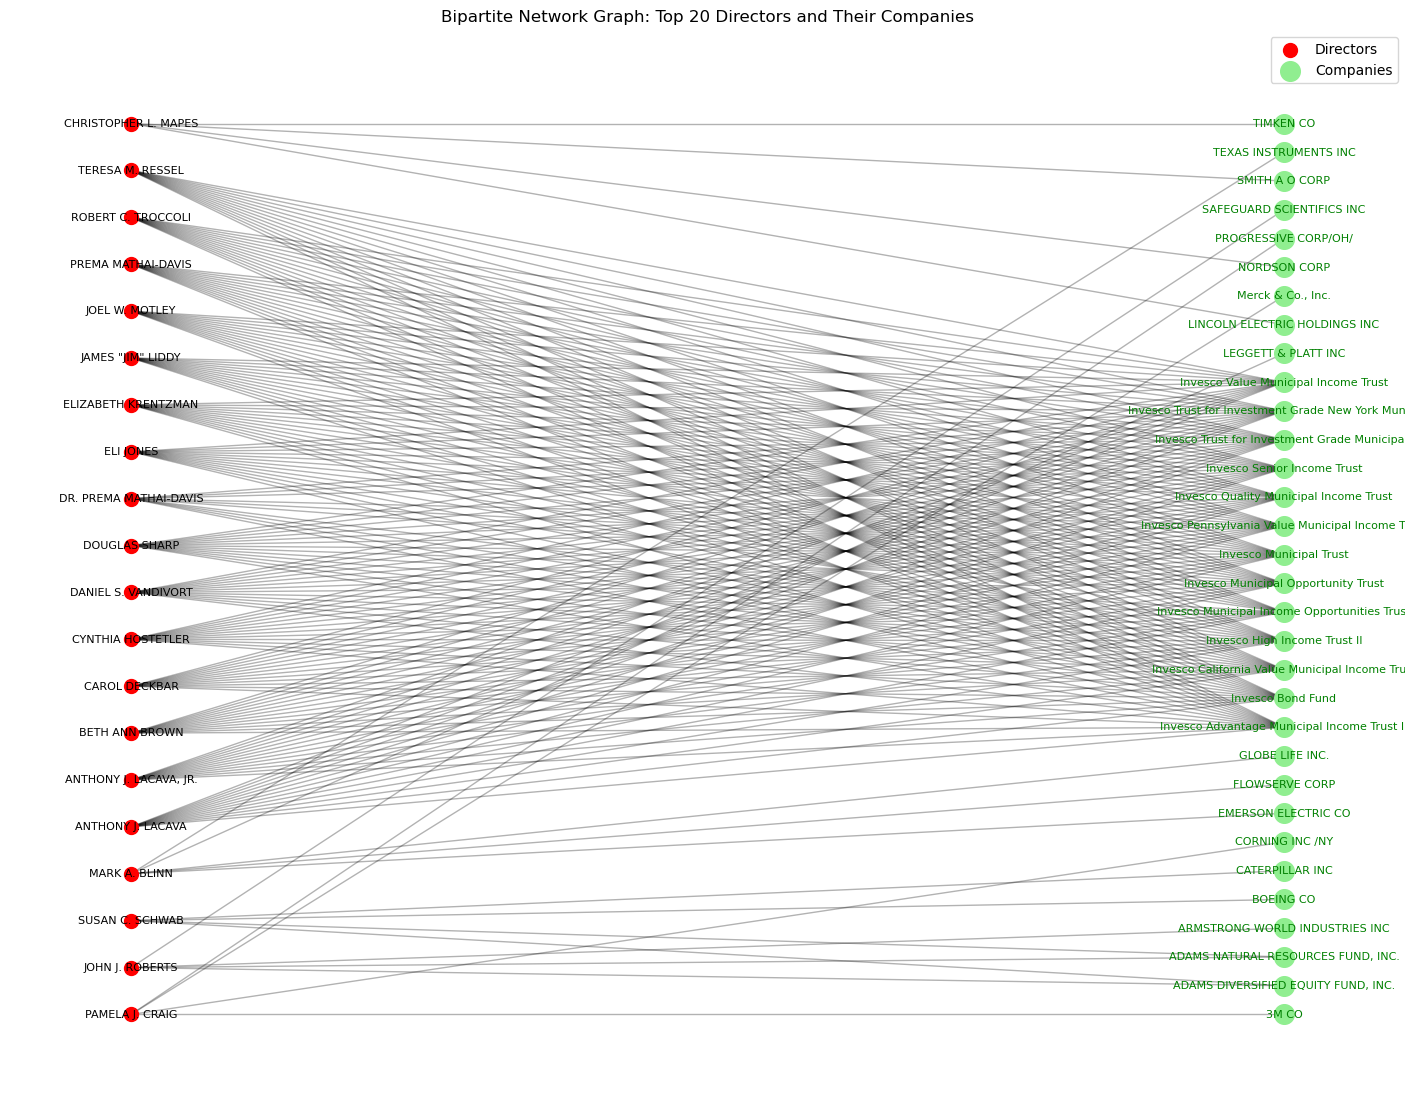

In [122]:
# Select Top 20 Directors by Number of Companies Served ---
top_20_directors = (
    merged_df.groupby('director_name')['company_name']
    .nunique()
    .sort_values(ascending=False)
    .head(20)
    .index
)

# Filter merged_df to include only rows for top 20 directors
filtered_df = merged_df[merged_df['director_name'].isin(top_20_directors)]

# Create the Bipartite Graph ---
G = nx.Graph()

# Add director nodes with prefix 'D_'
director_nodes = filtered_df['director_name'].unique()
G.add_nodes_from(['D_' + name for name in director_nodes], bipartite='directors')

# Add company nodes with prefix 'C_'
company_nodes = filtered_df['company_name'].unique()
G.add_nodes_from(['C_' + name for name in company_nodes], bipartite='companies')

# Add edges between directors and companies
edges = [
    ('D_' + row['director_name'], 'C_' + row['company_name'])
    for _, row in filtered_df.iterrows()
]
G.add_edges_from(edges)

print(f"Filtered Graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Visualization ---

# Separate the two sets of nodes
directors = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'directors']
companies = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'companies']

# Layout
from networkx.drawing.layout import bipartite_layout
pos = bipartite_layout(G, directors)

plt.figure(figsize=(18, 14))

# Draw director nodes (red)
nx.draw_networkx_nodes(G, pos, nodelist=directors, node_color='red', node_size=100, label='Directors')

# Draw company nodes (light green)
nx.draw_networkx_nodes(G, pos, nodelist=companies, node_color='lightgreen', node_size=200, label='Companies')

# Draw edges (light grey)
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw company labels
company_labels = {node: node[2:] for node in companies}
nx.draw_networkx_labels(G, pos, labels=company_labels, font_size=8, font_color='green')

# Draw director labels
director_labels = {node: node[2:] for node in directors}
nx.draw_networkx_labels(G, pos, labels=director_labels, font_size=8, font_color='black')

plt.title("Bipartite Network Graph: Top 20 Directors and Their Companies")
plt.axis('off')
plt.legend(scatterpoints=1)
plt.show()

In [123]:
# Count how many companies each director is associated with
most_connected = (
    merged_df.groupby('name')['company_name']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'company_name': 'num_companies'})
)

# Display top 10 most connected directors
top_connected = most_connected.head(20)
print("Top 10 Most Connected Directors:")
print(top_connected)

Top 10 Most Connected Directors:
                      name  num_companies
0                Eli Jones             14
1          Eli Jones Ph.D.             14
2        James "Jim" Liddy             13
3            Douglas Sharp             13
4   Anthony J. LaCava, Jr.             13
5        James “Jim” Liddy             13
6        Cynthia Hostetler             13
7           Joel W. Motley             13
8      Elizabeth Krentzman             13
9       Prema Mathai-Davis             13
10           Carol Deckbar             13
11          Beth Ann Brown             13
12     Daniel S. Vandivort             13
13      Robert C. Troccoli             13
14        Teresa M. Ressel             13
15      William H. Osborne              6
16    James B. Miller, Jr.              6
17           Mark A. Blinn              5
18          Michael A. Loh              5
19          Robert E. Dean              5


In [124]:
#counts the number of times each gender appears in the gender column
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [125]:
#calculates the number of unique companies each director is associated with, and then sorts the results in ascending order
# Identifying directors with multiple board memberships.
# Detecting potential conflicts of interest.
# Prioritizing high-influence individuals in a network.

directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

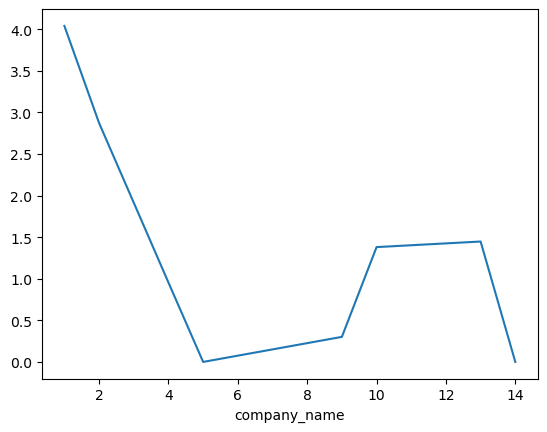

In [126]:
#Calculates how many directors hold directorships.
#Applies a logarithmic transformation to the counts.
#Plots the result as a graph

directorship_counts.value_counts().sort_index().map(math.log10).plot()

# TASK 2 
## CODE REPAIR/REPLACE

### Repair 4 (Code improved from above for better visualisation in comparison)

This code analyzes and visualizes the distribution of how many directorships each director holds, based on the merged_df dataset. It first counts the number of companies each director is associated with, then aggregates how many directors fall into each directorship count (e.g., how many hold 1, 2, 3, etc. positions). To improve visualization of skewed data, it applies a log10 transformation to the counts and plots the results, with the number of directorships on the x-axis and the log-transformed count of directors on the y-axis. The resulting line plot reveals patterns such as whether directorships are concentrated among a few individuals or more evenly distributed.

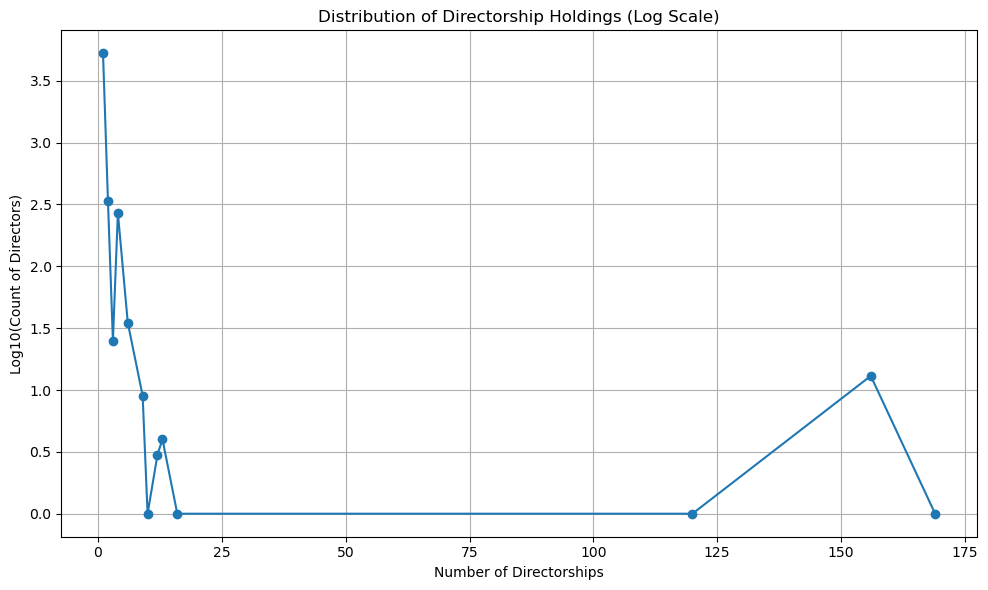

In [132]:
# Count how many companies each director is associated with
directorship_counts = merged_df['director_name'].value_counts()

# Group by number of directorships (i.e., how many directors have 1, 2, 3... roles)
counts_distribution = directorship_counts.value_counts().sort_index()

# Apply log10 transformation to y-axis values for better scaling
log_counts = np.log10(counts_distribution)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(log_counts.index, log_counts.values, marker='o', linestyle='-')
plt.xlabel('Number of Directorships')
plt.ylabel('Log10(Count of Directors)')
plt.title('Distribution of Directorship Holdings (Log Scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

The graph displays the distribution of directorship holdings among directors, using a log10 scale on the y-axis to account for skewed data. It shows that the vast majority of directors serve on a small number of boards—typically one to five—with the frequency dropping off sharply as the number of directorships increases. A few directors hold a notably large number of directorships (e.g., over 150), which is highly uncommon and appears as outliers on the right side of the graph. The log scale reveals the exponential nature of the distribution, emphasizing that multi-board memberships are rare and heavily concentrated among a small group of individuals.

In [128]:
import networkx #NetworkX is a powerful Python package used for creating, analyzing, and visualizing graphs/networks.
import networkx.algorithms #NetworkX is a powerful Python package used for creating, analyzing, and visualizing graphs/networks.
graph = networkx.Graph() #Creates an empty undirected graph and assigns it to the variable graph.

### Code not working / Improved code below.

In [59]:
# #computes centrality measures for nodes in the largest connected graph (people + companies),
# #marks whether each node is a person (director) or a company.

# %%time
# centrality = pandas.DataFrame({
#     'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
#     'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
# })
# centrality['is_person'] = centrality.index.map(lambda x: x in people)

UsageError: Line magic function `%%time` not found.


In [136]:
start = time.time()

# Compute centrality measures with adjusted parameters
eigen_centrality = nx.eigenvector_centrality(biggest_connected_graph, max_iter=1000, tol=1e-06)
degree_centrality = nx.degree_centrality(biggest_connected_graph)
betweenness_centrality = nx.betweenness_centrality(biggest_connected_graph)

# Create DataFrame
centrality = pd.DataFrame({
    'eigen': pd.Series(eigen_centrality),
    'degree': pd.Series(degree_centrality),
    'betweenness': pd.Series(betweenness_centrality)
})

# Optional: Label whether the node is a person (director)
centrality['is_person'] = centrality.index.map(lambda x: x in people)

end = time.time()
print(f"Centrality computation completed in {end - start:.2f} seconds")

Centrality computation completed in 144.68 seconds


In [137]:
# Create plot_df from your centrality measures
plot_df = centrality_df.copy()
plot_df.columns = ['degree', 'eigen', 'betweenness']  # ensure columns are named correctly

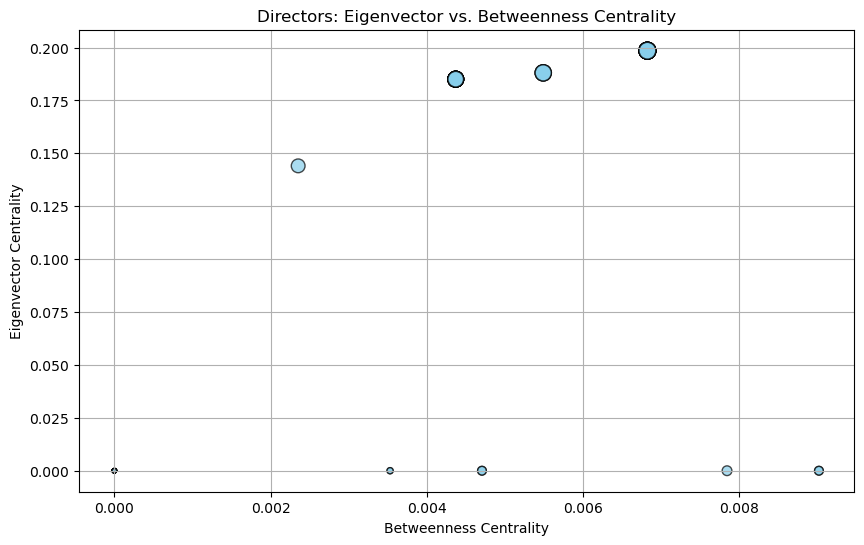

In [138]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    plot_df['betweenness'],        # x-axis
    plot_df['eigen'],              # y-axis
    s=plot_df['degree'] * 500,     # size of points
    c='skyblue',                   # fixed color
    alpha=0.7,
    edgecolor='k'
)

plt.title('Directors: Eigenvector vs. Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Eigenvector Centrality')
plt.grid(True)
plt.show()

# Task 1

## Centrality Extension

Betweenness Centrality has been included to the “eigen” and “degree” measures as it adds meaningful measure to the analysis. Betweenness Centrality assists identifying connections that lie on the shortest paths between other groups (Bridge or Brokers). The director's position bridges clusters of companies, facilitating the exchange of ideas and influence between disconnected firms and potentially signalling merger activity or industry convergence.

## Degree Centrality:
High Degree Centrality: A director with a high degree centrality is connected to many of the 13 companies. This might indicate that they have significant influence or control across multiple companies, potentially allowing them to shape decisions or facilitate collaborations.
Low Degree Centrality: A director with a low degree centrality is connected to few or none of the 13 companies. This might suggest they have limited influence or involvement in the corporate network.
In the context of the project, identifying directors with high degree centrality could help understand who the key players are in the network and how they might be leveraging their connections.

## Eigenvector Centrality:
High Eigenvector Centrality: A director with a high eigenvector centrality is not only connected to many companies but also connected to other influential directors. This might indicate that they are part of a powerful inner circle or elite group within the corporate network.
Low Eigenvector Centrality: A director with a low eigenvector centrality might be connected to less influential companies or directors, potentially limiting their ability to exert influence or access valuable resources.
In the project, eigenvector centrality could help identify directors who are part of a larger, more influential network, and how they might be using their connections to shape the corporate landscape.

## Betweenness Centrality:
High Betweenness Centrality: A director with a high betweenness centrality acts as a bridge or intermediary between different companies or groups of directors. This might indicate that they have unique access to information, resources, or opportunities, and can facilitate collaborations or negotiations between different parties.

Low Betweenness Centrality: A director with a low betweenness centrality might be part of a more isolated group or have limited connections to other companies or directors, potentially limiting their ability to facilitate interactions or access new opportunities.
In the project, betweenness centrality could help identify directors who play a crucial role in facilitating interactions and collaborations within the corporate network, and how they might be leveraging their position to access valuable resources or information.
By analyzing these centrality measures, the project aims to gain a deeper understanding of the corporate network's structure and dynamics, and how individual directors might be influencing or shaping the network through their connections and positions.

In [139]:
#Create a new DataFrame (people_df) that contains:
#Only person nodes (directors) from the centrality results.
#And adds to them their corresponding compensation and demographic data.

#people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

# Convert centrality measures to a DataFrame
centrality_df = pd.DataFrame({
    'degree': nx.degree_centrality(G),
    'eigen': nx.eigenvector_centrality(G),
    'betweenness': nx.betweenness_centrality(G)
})

# Keep only director nodes (which start with 'D_')
people_df = centrality_df[centrality_df.index.str.startswith('D_')].copy()

# Clean the index to match the compensation/demographics index
# Assuming compensation_and_demographics uses plain names (no 'D_' prefix)
people_df.index = people_df.index.str[2:]  # Remove 'D_' prefix

# Merge with the compensation and demographics data
people_df = people_df.merge(compensation_and_demographics, left_index=True, right_index=True)



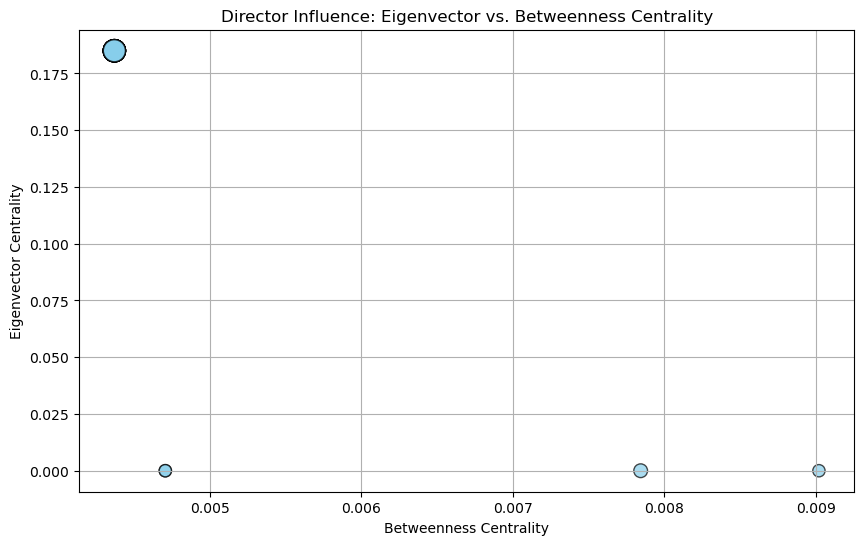

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    people_df['betweenness'],        # x-axis
    people_df['eigen'],              # y-axis
    s=people_df['degree'] * 1000,    # size of bubbles
    c='skyblue',                     # color of points
    alpha=0.7,
    edgecolor='k'
)

plt.title('Director Influence: Eigenvector vs. Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Eigenvector Centrality')
plt.grid(True)
plt.show()

This scatter plot analyzes director influence by comparing eigenvector centrality (quality of connections to other influential directors) against betweenness centrality (how often they act as bridges between other directors), with bubble size representing total connections. The data reveals a stark hierarchy: one director has exceptionally high eigenvector centrality (~0.18) but low betweenness centrality, indicating they're deeply embedded within an elite group of highly connected directors, while three other directors have very low eigenvector centrality but varying bridging roles. This pattern suggests a typical corporate board network structure where a few elite directors dominate the influential core while others operate on the periphery, connecting different parts of the network but lacking access to the most powerful circles

C:\Users\61424\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


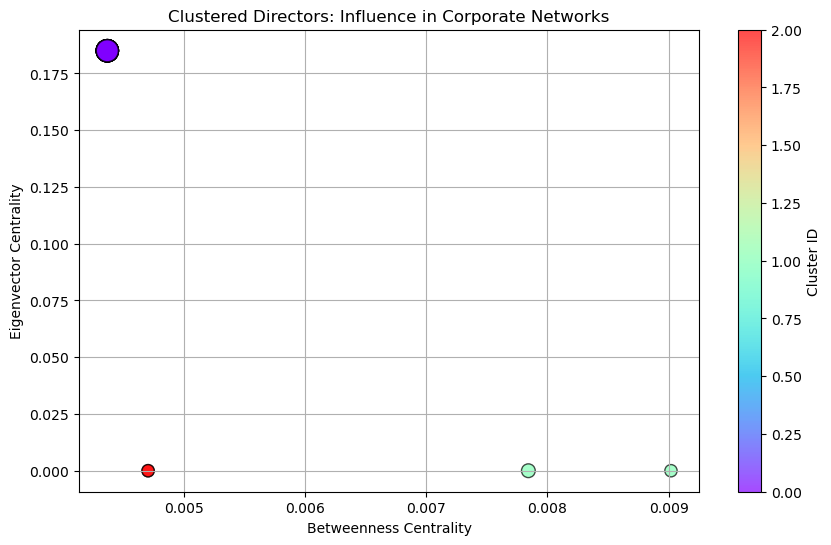

In [141]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare the data
X = people_df[['degree', 'eigen', 'betweenness']]
X_scaled = StandardScaler().fit_transform(X)

# Fit KMeans (choose 3-5 clusters to explore)
kmeans = KMeans(n_clusters=3, random_state=42)
people_df['cluster'] = kmeans.fit_predict(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    people_df['betweenness'],
    people_df['eigen'],
    s=people_df['degree'] * 1000,
    c=people_df['cluster'],
    cmap='rainbow',
    alpha=0.7,
    edgecolor='k'
)

plt.title('Clustered Directors: Influence in Corporate Networks')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Eigenvector Centrality')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()

The graph visualizes clustered directors based on their influence within corporate board networks, using two centrality measures: betweenness centrality on the x-axis and eigenvector centrality on the y-axis. Each point represents a director, with the color indicating cluster membership and the size representing relative influence. Betweenness centrality captures how often a director lies on the shortest path between others (indicating brokerage power), while eigenvector centrality reflects a director’s connection to other well-connected directors (indicating prestige). The clustering (shown by different colors) likely stems from an unsupervised algorithm like KMeans or DBSCAN, used to group directors with similar network roles. From the plot, we observe that one cluster (purple) contains directors with notably high eigenvector centrality but low betweenness, suggesting they are highly influential through their connections, while others are more peripheral or serve bridging roles.

In [142]:
#Sort the people_df DataFrame by the eigenvector centrality score — from most central to least central.

people_df.sort_values('eigen', ascending=False)

,degree,eigen,betweenness,age,compensation,gender,log_compensation,cluster
DOUGLAS SHARP,0.254902,1.850187e-01,0.004370,50,0,male,0.000000,0
TERESA M. RESSEL,0.254902,1.850187e-01,0.004370,62,3190130,female,6.503809,0
"ANTHONY J. LACAVA, JR.",0.254902,1.850187e-01,0.004370,68,3461400,male,6.539252,0
BETH ANN BROWN,0.254902,1.850187e-01,0.004370,56,6363810,female,6.803717,0
CAROL DECKBAR,0.254902,1.850187e-01,0.004370,62,43263,female,4.636127,0
CYNTHIA HOSTETLER,0.254902,1.850187e-01,0.004370,62,3371400,female,6.527810,0
DANIEL S. VANDIVORT,0.254902,1.850187e-01,0.004370,69,3353265,male,6.525468,0
ELI JONES,0.254902,1.850187e-01,0.004370,63,3063255,male,6.486183,0
ELIZABETH KRENTZMAN,0.254902,1.850187e-01,0.004370,65,3408245,female,6.532531,0
"JAMES ""JIM"" LIDDY",0.254902,1.850187e-01,0.004370,65,27531,male,4.439838,0


# TASK 3. Existing dataset not currently being used.

Director ELIZABETH KRENTZMAN was retrieved however hte purpose of querry is unknown and is not used inthe analysis.


In [53]:
# Retrieve all rows from the DataFrame df where the director_name is exactly "ELIZABETH KRENTZMAN".

df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [54]:
import sklearn.cluster

In [143]:
import sklearn.preprocessing

#To scale (normalize) certain columns of the people_df DataFrame using the RobustScaler, making the data less sensitive to outliers.
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [144]:
# Cluster the directors (people) into groups based on their scaled age, 
#compensation, and centrality metrics using the DBSCAN clustering algorithm, 
#then see how many people fall into each cluster.

dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
-1    17
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

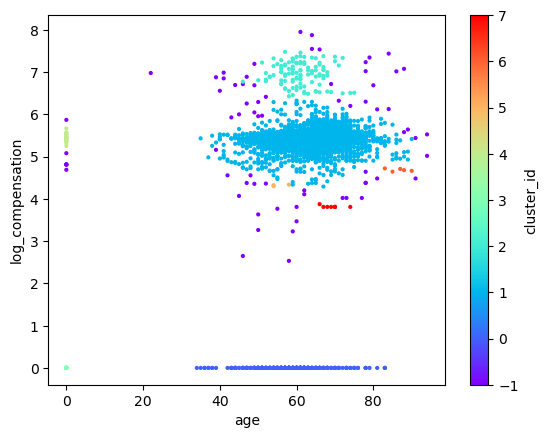

In [57]:
#Create a scatter plot to visualize the relationship between age and log_compensation 
#of people in people_df, colored by their assigned cluster_id.

people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [58]:
#Retrieve all the data for the row whose index is 
#'ELIZABETH KRENTZMAN' from the people_df DataFrame.
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

# TASK 4

## Complementary dataset details.

The ESG dataset provides company-level ESG (Environmental, Social, and Governance) scores, ratings, and classifications for publicly traded firms, enabling analysis of corporate sustainability performance across industries and its relationship to financial metrics and societal goals.

This integrated analysis combines ESG performance data with directorship information to explore how individual directors may influence corporate ethics across companies. By merging datasets on ESG scores and board memberships, we can identify patterns such as directors serving on multiple boards and whether their presence correlates with strong or weak ethical performance indicators (e.g., low governance scores or poor environmental ratings). Directors with high centrality in corporate networks or those repeatedly associated with low ESG scores may signal ethical risks, conflicts of interest, or weak oversight. Conversely, those linked to consistently high ESG outcomes may reflect ethical leadership and sound corporate governance practices, offering insight into which individuals foster responsible business behaviour.

However, while this approach can highlight potentially problematic or exemplary directors, it also comes with limitations. ESG scores themselves may vary in methodology and not fully capture unethical behaviour or internal company issues. Moreover, correlation does not imply causation—low ESG performance may be influenced by factors outside a director’s control, such as industry constraints or economic cycles. There's also a risk of overinterpreting results from sparse or biased data. Despite these limitations, this analysis provides a valuable ethical lens for investors, analysts, and regulators to evaluate the broader impact of directorship networks on corporate responsibility.

## Complementary Dataset

In [145]:
#Complementary dataset

file_path = r"C:\Users\61424\Downloads\assignment3\data (1).csv"
df = pd.read_csv(file_path)
df.head()

,ticker,name,currency,exchange,industry,logo,weburl,environment_grade,environment_level,social_grade,...,governance_grade,governance_level,environment_score,social_score,governance_score,total_score,last_processing_date,total_grade,total_level,cik
0,dis,Walt Disney Co,USD,"NEW YORK STOCK EXCHANGE, INC.",Media,https://static.finnhub.io/logo/ef50b4a2b263c84...,https://thewaltdisneycompany.com/,A,High,BB,...,BB,Medium,510,316,321,1147,19-04-2022,BBB,High,1744489
1,gm,General Motors Co,USD,"NEW YORK STOCK EXCHANGE, INC.",Automobiles,https://static.finnhub.io/logo/9253db78-80c9-1...,https://www.gm.com/,A,High,BB,...,B,Medium,510,303,255,1068,17-04-2022,BBB,High,1467858
2,gww,WW Grainger Inc,USD,"NEW YORK STOCK EXCHANGE, INC.",Trading Companies and Distributors,https://static.finnhub.io/logo/f153dcda-80eb-1...,https://www.grainger.com/,B,Medium,BB,...,B,Medium,255,385,240,880,19-04-2022,BB,Medium,277135
3,mhk,Mohawk Industries Inc,USD,"NEW YORK STOCK EXCHANGE, INC.",Consumer products,https://static.finnhub.io/logo/26868a62-80ec-1...,https://mohawkind.com/,A,High,B,...,BB,Medium,570,298,303,1171,18-04-2022,BBB,High,851968
4,lyv,Live Nation Entertainment Inc,USD,"NEW YORK STOCK EXCHANGE, INC.",Media,https://static.finnhub.io/logo/1cd144d2-80ec-1...,https://www.livenationentertainment.com/,BBB,High,BB,...,B,Medium,492,310,250,1052,18-04-2022,BBB,High,1335258


# TASK 5 (b)

## Data Implementations

In [146]:
esg_df = pd.read_csv(r"C:\Users\61424\Downloads\data (1).csv")
print(esg_df.columns)

Index(['ticker', 'name', 'currency', 'exchange', 'industry', 'logo', 'weburl',
       'environment_grade', 'environment_level', 'social_grade',
       'social_level', 'governance_grade', 'governance_level',
       'environment_score', 'social_score', 'governance_score', 'total_score',
       'last_processing_date', 'total_grade', 'total_level', 'cik'],
      dtype='object')


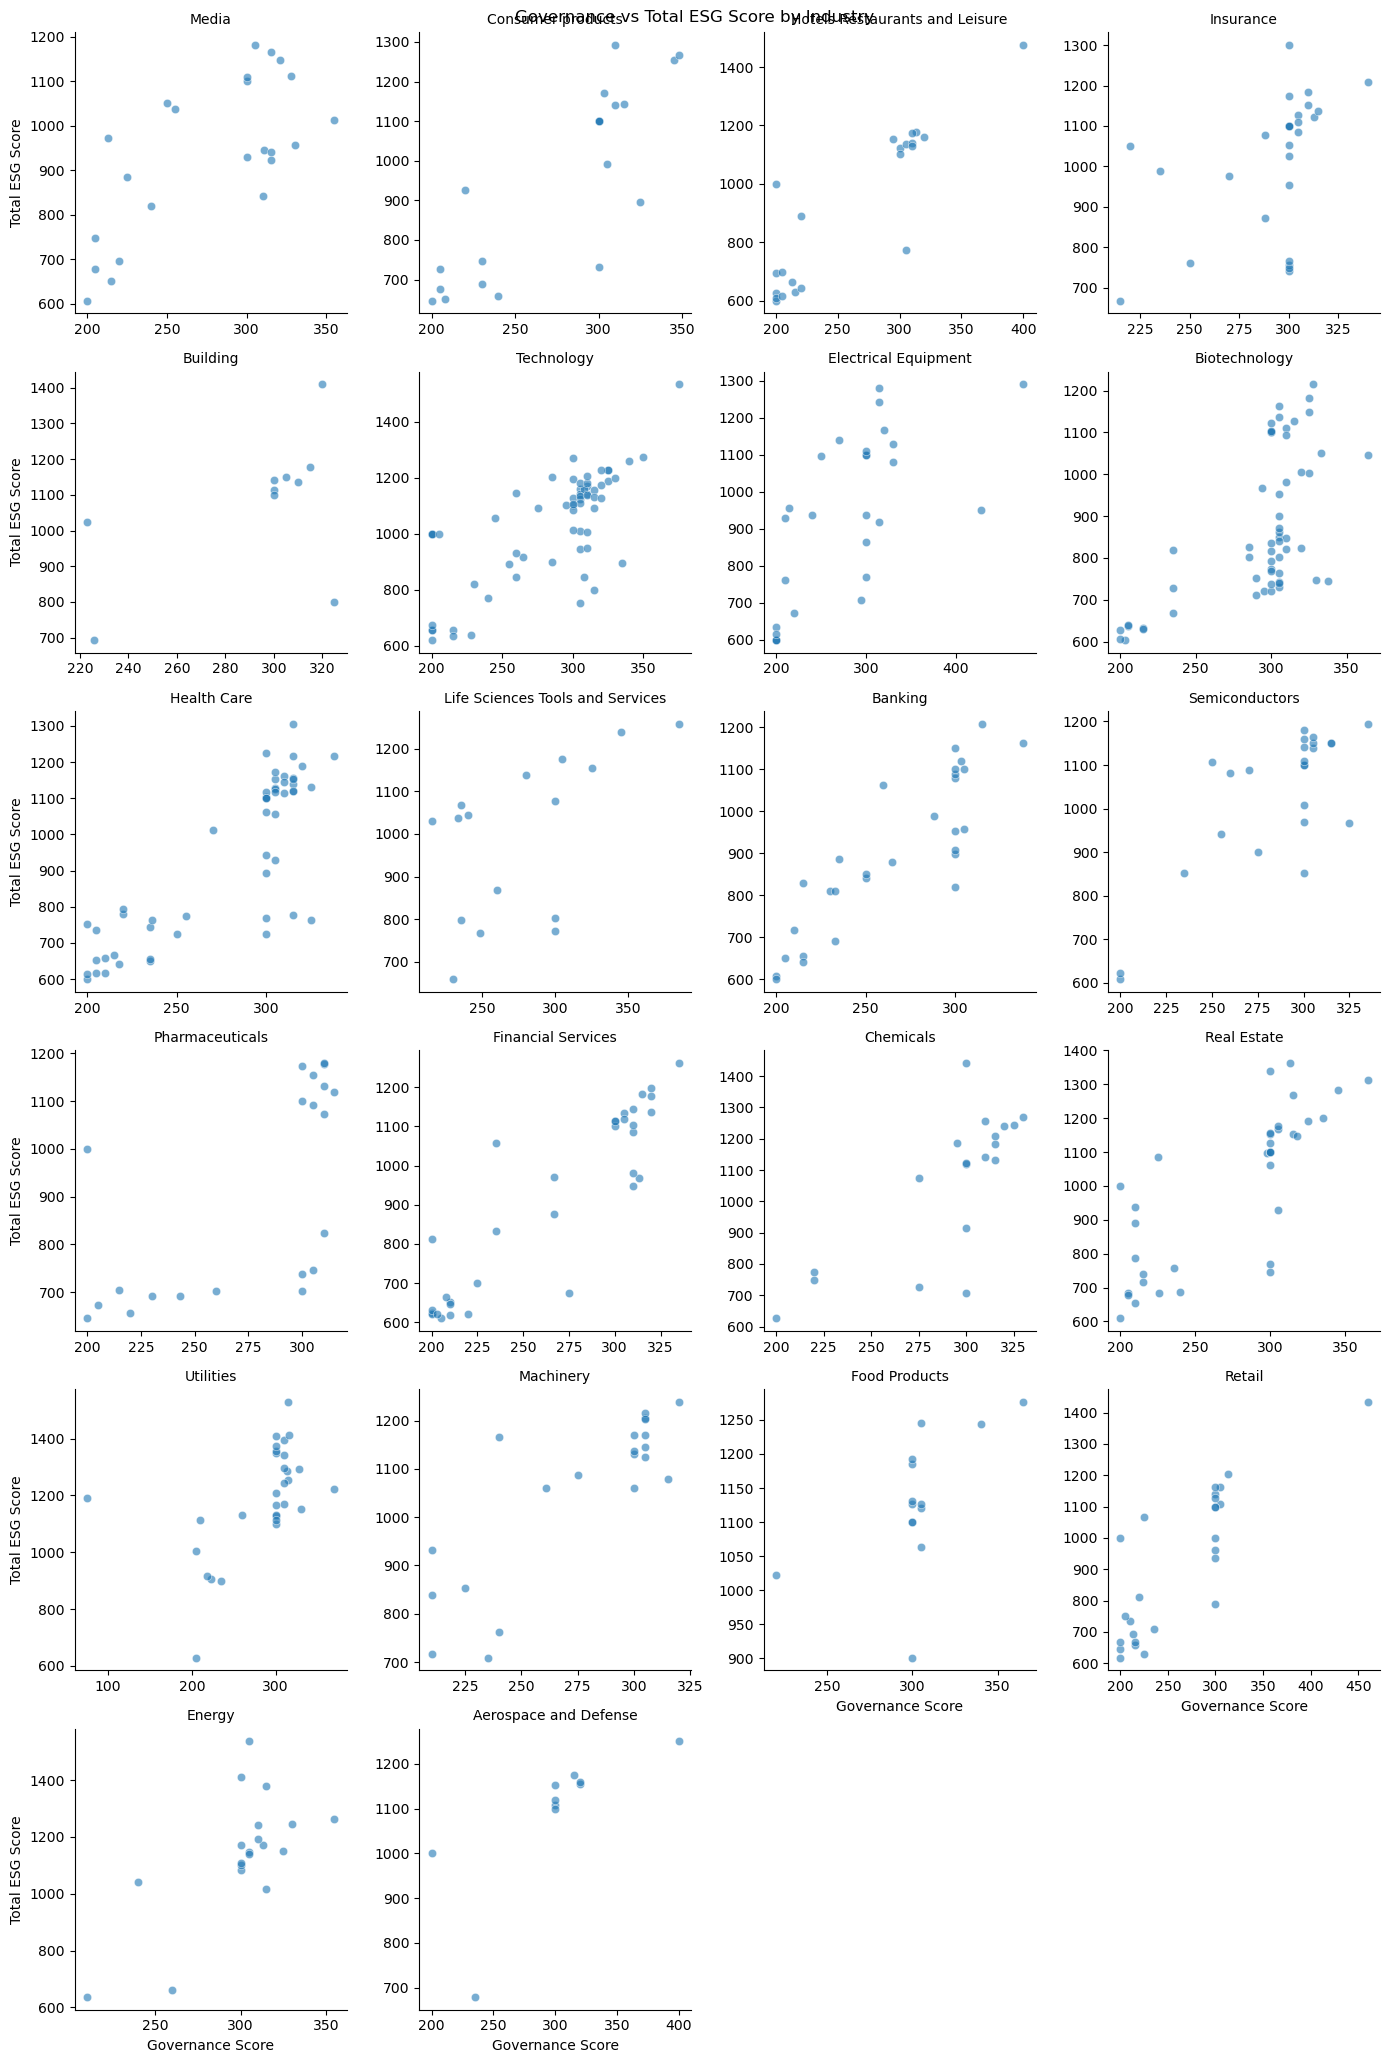

In [147]:
# Scatter Plots by Industry

# Convert scores to numeric
df['governance_score'] = pd.to_numeric(df['governance_score'], errors='coerce')
df['total_score'] = pd.to_numeric(df['total_score'], errors='coerce')

# Filter to industries with enough data points (at least 10 companies)
industry_counts = df['industry'].value_counts()
top_industries = industry_counts[industry_counts >= 10].index
df_filtered = df[df['industry'].isin(top_industries)]

# Create facet grid
g = sns.FacetGrid(df_filtered, col='industry', col_wrap=4, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x='governance_score', y='total_score', alpha=0.6)
g.set_titles("{col_name}")
g.set_axis_labels("Governance Score", "Total ESG Score")
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Governance vs Total ESG Score by Industry")
plt.tight_layout()
plt.show()

The faceted scatter plot reveals clear industry-specific patterns in the relationship between governance scores and total ESG performance. Sectors such as Technology, Health Care, and Financial Services exhibit a moderate positive correlation, where higher governance scores tend to align with better overall ESG outcomes. In contrast, industries like Utilities and Pharmaceuticals show greater variability and outliers, suggesting inconsistent influence of governance within those sectors. Meanwhile, industries like Food Products and Retail display tighter clustering, indicating more uniform governance-ESG dynamics. Overall, this visualization offers improved clarity over the aggregated scatter plot by allowing more nuanced, sector-based ethical insights.

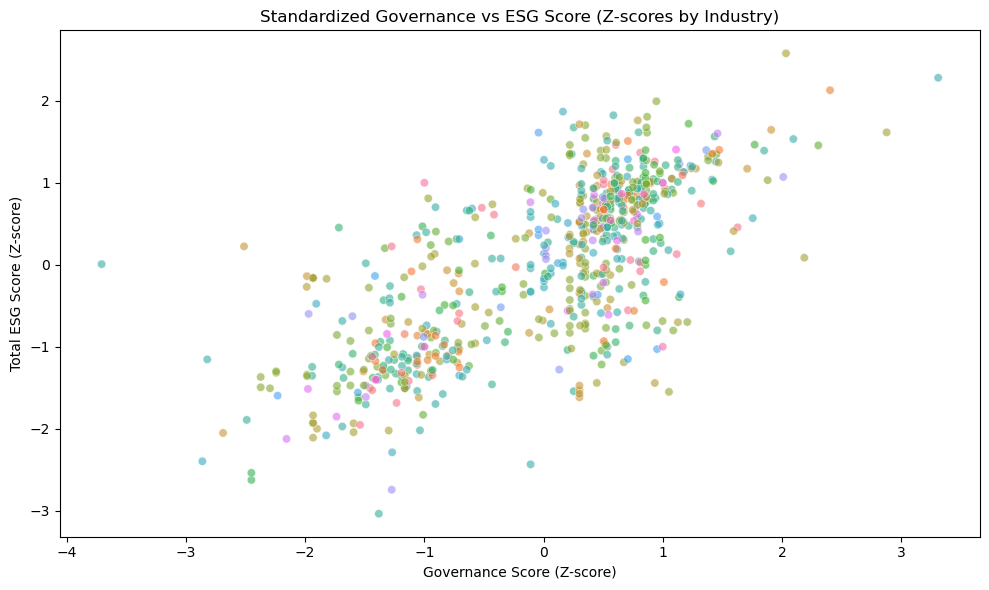

In [148]:
# Normalized Scores by Industry
# Show standardized scores (z-scores) to emphasize variation within each industry.

from scipy.stats import zscore

# Only keep necessary columns
columns = ['industry', 'governance_score', 'total_score']
df_z = df[columns].dropna()

# Normalize scores within each industry group
df_z[['gov_z', 'total_z']] = df_z.groupby('industry')[['governance_score', 'total_score']].transform(zscore)

# Scatter plot of normalized scores
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_z, x='gov_z', y='total_z', hue='industry', alpha=0.6, legend=False)
plt.title("Standardized Governance vs ESG Score (Z-scores by Industry)")
plt.xlabel("Governance Score (Z-score)")
plt.ylabel("Total ESG Score (Z-score)")
plt.tight_layout()
plt.show()

The scatter plot displays standardized (z-score) values of governance scores against total ESG scores across industries. A clear positive trend is visible, suggesting that companies with above-average governance performance within their respective industries tend to also score higher in total ESG performance. While some dispersion and outliers are present, the overall clustering along a diagonal axis confirms a moderately strong linear relationship. The use of z-scores enhances interpretability, highlighting how relative governance strength within an industry correlates with broader ESG outcomes.

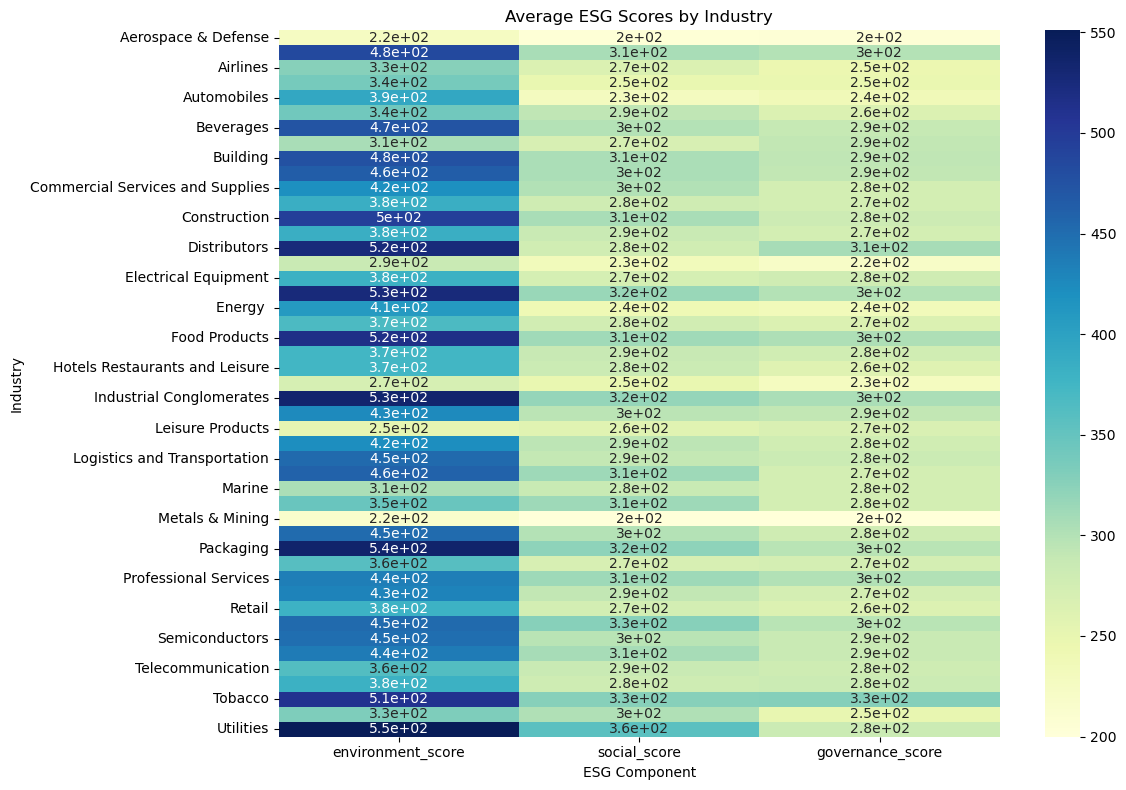

In [149]:
# ESG Score Heatmap by Industry
# This can show where influence might be concentrated or lacking across industries.

# Group and average ESG scores by industry
industry_scores = df.groupby('industry')[['environment_score', 'social_score', 'governance_score']].mean().dropna()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(industry_scores, annot=True, cmap='YlGnBu')
plt.title('Average ESG Scores by Industry')
plt.xlabel('ESG Component')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()

This heatmap illustrates the average ESG component scores—environment, social, and governance—across various industries. Darker shades represent higher average scores, allowing quick visual comparison. Notably, industries such as Utilities, Packaging, and Professional Services score particularly high in environmental and social dimensions, while governance scores remain relatively moderate and uniform across industries. In contrast, sectors like Tobacco and Metals & Mining show lower scores across all ESG dimensions, especially in governance. The visualization effectively highlights how different industries prioritize or perform in specific ESG areas, offering insight into sector-specific ethical strengths and weaknesses.

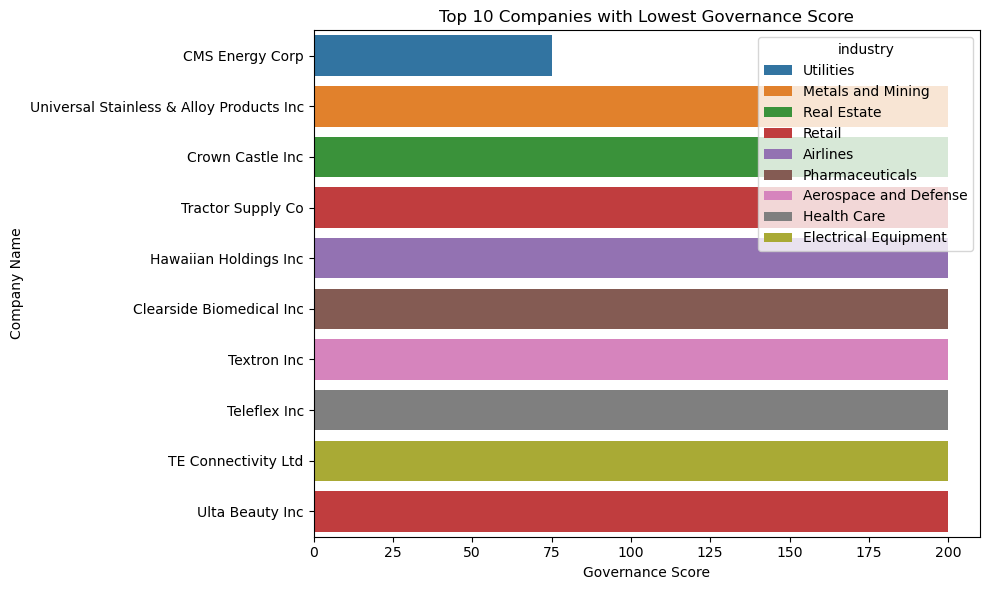

In [150]:
# Top 10 Companies with Lowest Governance Scores
# Shows companies with highest risk of ethical influence problems.

# Sort by governance_score ascending (low is bad)
top_risk = df[['name', 'industry', 'governance_score']].dropna().sort_values(by='governance_score').head(10)

# Bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=top_risk, y='name', x='governance_score', hue='industry')
plt.title('Top 10 Companies with Lowest Governance Score')
plt.xlabel('Governance Score')
plt.ylabel('Company Name')
plt.tight_layout()
plt.show()

This horizontal bar chart displays the top 10 companies with the lowest governance scores, spanning a diverse range of industries. CMS Energy Corp, from the Utilities sector, has the lowest governance score overall. The remaining companies—such as Universal Stainless & Alloy Products Inc (Metals and Mining), Crown Castle Inc (Real Estate), and Ulta Beauty Inc (Retail)—also exhibit governance scores close to the lower threshold of 200. The variety of industries represented, including Health Care, Aerospace and Defense, and Pharmaceuticals, indicates that weak governance performance is not limited to a specific sector. This suggests governance challenges can be widespread and industry-agnostic.

# TASK 5 (c)

## ETHICS

The Venture Capital Fund's approach to expediting the company's sale raises significant concerns about compromising fiduciary duties, exerting undue influence, and prioritizing short-term financial gains over long-term sustainability and growth, potentially leading to decisions that benefit the fund at the expense of the company and its stakeholders. This could damage the company's reputation, erode trust among stakeholders, including employees, customers, and minority shareholders, and ultimately harm the company's long-term prospects. Potential consequences of this approach include loss of trust, negative impacts on employees, such as restructuring or downsizing, and long-term harm to the company's growth and development. 

The fund's actions may also lead to a lack of investment in research and development, neglect of core values and mission, and an overall decline in the company's competitiveness and innovation. To mitigate these risks, the fund should prioritize transparency in their decision-making process, align their interests with those of the company and its stakeholders, and respect the board's fiduciary duties to ensure responsible and sustainable decision-making that benefits all parties involved. By taking a more balanced and sustainable approach, the fund can help ensure the company's long-term success, maintain the trust and confidence of its stakeholders, and foster a positive and productive work environment that supports the company's growth and development. This would involve considering the potential consequences of their actions, engaging in open and honest communication with stakeholders, and prioritizing decisions that support the company's long-term goals and values.